# Statistical tests, from scratch

In this chapter we will build up the foundations of statistical tests.  Starting from a foundational example and building on our understanding from there.  We will be implementing some statistical tests in order to deepen our understanding.  

Statistical tests come to us from descriptive statistics.  By making use of descriptive statistics in conjunction, we can build up to analytic tools for discerning truth.  In this way, we can see a statistical test as a clever use of descriptive statistics in order to better understand the world around us.

## Foundational Example

Let us begin with the foundational example, that of milk poured into tea and tea poured into milk.

### Set up

Assume that a person claims they can tell the difference between tea poured into milk and milk poured into tea.  Such an ability may seem unlikely.  But how unlikely is it?  One way to verify whether or not an individual poses such an ability is to devise an experiment.  

As an aside, all of science is either experimentally or theoretically evaluated.  Where experimental evaluation is always done via the use of statistics and probability to evaluate the data of an experiment.  And theoretical evaluation comes to us from the manipulation of equations to discern truth.  

Before we go through the logic of the experimental design for this experiment, see if you can come up with your own experimental design.  What would you account for in your experiment?  How would you ensure you can trust your results?  What is your null hypothesis?  What is your alternative hypothesis?  How sure will you be of your results?  And how will you know?

These are many of the foundational questions one needs to consider before starting out an experiment.  I think this blog post does a decent job of introducing more on the topic of experimental design: https://towardsdatascience.com/data-science-you-need-to-know-a-b-testing-f2f12aff619a

Without further ado, the set up:

A researcher randomly decided whether to pour tea into milk or milk into tea for eight cups of tea.  Then he presented the eight cups of tea to the person claiming to be able to tell the difference.  Here the null hypothesis is that the person cannot tell which tea cup is which.  The alternative hypothesis is that they cannot.  If the person gets all eight tea cups correctly, then the researcher believed we could reject the null hypothesis and that it was likely the alternative hypothesis was true.

How likely was it that the alternative hypothesis was true?  Well thats actually easy to calculate.  Because there are eight cups of tea and each was randomly assigned to case one and case two, that meant that there was no conditional information between cups of tea.  This means that the probability of getting all eight cups of tea correct is:

$$ \frac{1}{2^{8}} = \frac{1}{256} \approx 0.003 $$

So there is less than a 1% chance that the person gets all eight cups right, given that they were guessing.  So if they do get all eight right, we should assume there is a pretty good chance that they know how to tell the difference.  But is that enough?  Are we confident in saying that this person knows how to do this?  

Well one way you could check is run the experiment multiple times on multiple days and check the results.  The chance of any individual one of these tests getting the alternative hypothesis goes up, but it's increasingly likely that the typical case will emerge for most of the tests.  How likely a test is to fail to give a correct response is related to its statistical power - the chance of getting a false positive.  This general procedure of running an experiment multiple times is called a replication study and it is crucial to science.  If you cannot replicate an experiment, then the experiment should not be trusted.  But I digress.

There are some general features of our experiment that we should make explicit:

1. Our tea took on one of two states - tea poured into milk or milk poured into tea.  In general we usually break up our experiment into two possible cases - test and control.  In the test set a "treatment" is applied and for the control set either no treatment is given or a placebo is given.  

2. Enough trials were performed during the experiment to make the possability of an accidental false positive fairly unlikely.  In this case, a less than 1% chance.  For some experiments this is nowhere near enough tolerance.  It really all depends on what you are trying to measure and how important getting it right is.  The industry agreed upon standard is 5% margin of error, which might be good enough or maybe not.

3. After the experiment, we should not be 100% confident in our results.  We should be reasonably confident.  We should be as confident as the margin of error, in this case about 99.7% confident.  But we should not, nor should we ever really be 100% confident in a result.  And we should increase our confidence only after some number of replication studies have been performed.  This shows us the importance of creating experiments where replication is relatively easy to perform.  If replicating our experiment is very, very hard, then it might be a bad experiment.  Of course, it all depends.  

## A Digression Into Computing Probabilities

* sample spaces
* probability identities
* multiplication principle
* pigeon hole principle
* permutations
* combinations

## Sample Spaces

A sample space is the space of all possible outcomes for a given "event".  We define an event as the thing of study.  Speaking in vague terms like this can be difficult, so let's make things clearer with some examples:

### Gambling

While gambling can be a terrible habit, it's great for studying probability.  This is because gambling is about games of chance.  In this "chance" element we can find a rigorous ground to study the precepts of probability.  Let's start with the simplest possible gambling game, a coin flip.

#### Coin flip

In order to study this "game" we need to consider first the space of possible outcomes.  In our case, much like the tea example there are two possible "outcomes", that is two possible states that the coin can end up in after it is flipped.  You may think this isn't terribly complex, but it can still give us much fertile ground to study the world, as well as to develope many techniques which can be applied elsewhere.  In fact, the computers we rely on every day share some similar properties to this "simple" binary outcome space.  But I digress.

Let's start off our analysis by looking at the sample space for a single flip.  That is:

Sample Space for a coin := `{Heads, Tails}`

In mathematics we typically use a short hand so let's further refine our definition to:

Sample Space for a coin := `{H, T}`, where `H` stands for `Heads` and `T` stands for `Tails`.

So if our "game" is defined by people placing bets on heads or tails and then a single flip of the coin discerns who wins, we are done with our initial analysis.  What can we do next?  Well, now that we know the "space" of our possible samples in totality we can easy define the "probability" of each case occuring:

Assuming our coin is "fair" then the following is true:

* P(H) = 1/2
* P(T) = 1/2

This doesn't tell us how well or poorly we will do for a given toss of the coin.  However if we were to play many games placing a bet each time, we would know how well we would do "in the long run".  Let's try to visualize this.  In order to do so, we'll need a random "process" that selects one value half the time and another value the other half of the time.  Fortunately we have a such a "process", it's name is the Bernoulli distribution.  

Note: we are using the term "process" to mean the mathematical object that "randomly" produces data that models the real world.  In general anything that spits out data according to some notion of "randomness" we will define as a "process".

Here the reason we use the Bernoulli distribution as our "process" is because we can sample from this distribution to simulate what will happen with coin flips.  We might say that a Bernoulli distribution "models" coin flips in this case, because it accurately captures the essence of our interest of study.  And without having to actually flip any coins!

Now then, let's sample from our Bernoulli distribution and figure out what happens to our money over the long run placing single bets on single coin flips!

We'll need just a little bit more set up before we are ready to visualize:

1. We'll start with one dollar bets
2. Everytime we win we win a dollar
3. Everytime we lose we lose a dollar
4. The game ends when we run out of money.

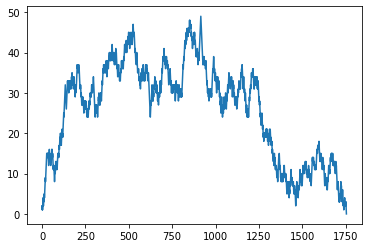

49


In [16]:
from scipy import stats
import matplotlib.pyplot as plt

probability = 0.5

money = 1

winnings_over_time = []
while money > 0:
    outcome = stats.bernoulli.rvs(probability, size=1)[0]
    if outcome == 1:
        money += 1
    else:
        money -= 1
    winnings_over_time.append(money)
    
plt.plot(winnings_over_time)
plt.show()
print(max(winnings_over_time))

Looks like we make some money for a while, going as high as 49 dollars.  But eventually we end up losing everything because when your odds are _always_ 50/50 eventually you'll hit a rough patch.  Another way we can analyze this game is by looking at how the probability converges to 50 % odds.  Let's look at that now:

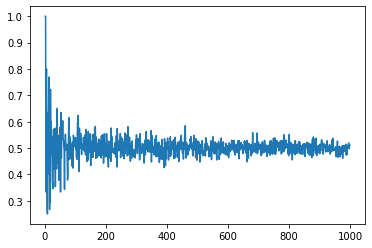

In [19]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

probability = 0.5

average_outcomes = []
for size in range(1000):
    average_outcomes.append(
        np.mean(stats.bernoulli.rvs(probability, size=size))
    )

plt.plot(average_outcomes)
plt.show()

As you can see, as the number of trials, that is the number of times we flip the coin goes up the expected probability, that is the number of times we get heads on average goes to 50%.  Notice how that band around 0.5 gets closer and closer.  This is because as we do more and more trials things become more and more normalized.  Another way to think of this is as the point of convergence.  We may never get to exactly 0.5, but we get ever closer to 0.5 as we take more trials into consideration.  That's why as we play increasingly more single bet games of flipping the coin, we get "increasingly close" to our theoretical expectation.

Just to continue on our digression let's look at another variant of this game.  What if now instead of placing bets each game, our total winnings was doubled for each successive head we saw in a row.  

So if we see 2 heads in a row we win two dollars, if we win three heads in a row we win 4 dollars, in general if we see "N" heads a row we see $2^{N}$ dollars.  Given this set up, do we think the game will still end with us losing it all?  Will we have much longer runs before that happens, assuming it's inevitable?

Let's do some experiments to find out:

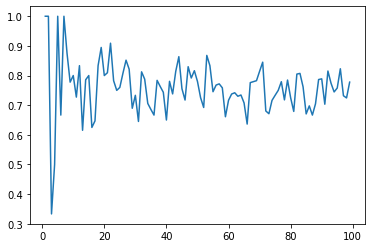

1.0


In [32]:
from scipy import stats
import matplotlib.pyplot as plt

def trial():
    probability = 0.5
    money = 1
    winnings_over_time = []
    consecutive_wins = 0
    num_iter = 0
    while money > 0:
        num_iter += 1
        outcome = stats.bernoulli.rvs(probability, size=1)[0]
        if outcome == 1:
            money += 2**consecutive_wins
            consecutive_wins += 1
        else:
            money -= 1
            consecutive_wins = 0
        winnings_over_time.append(money)
        if num_iter > 10000:
            break
    return winnings_over_time[-1] == 0

probability_win_something = []
for number_of_trials in range(1, 100):
    lose_all_money = 0
    win_something = 0
    for _ in range(number_of_trials):
        if trial():
            win_something += 1
        else:
            lose_all_money += 1
    probability_win_something.append(
        win_something/(win_something+lose_all_money)
    )
plt.plot(list(range(1, 100)), probability_win_something)
plt.show()
print(max(probability_win_something))

For each of the above talk about how to use this in an experimental context.  The key is a limited sample space of possible outcomes.

## What to do when our sample space is not well defined?

# Writing Our Own Statistical Tests

Now that we know how to set up an experiment, let's come up with a set of statistical tools to help us test hypotheses in general, without having to calculate the specifics of the test every time.

## Implementing T-Tests

There are a number of t-tests.  For each t-test we will be using a worked example to illustrate how to use our implementation.  Technically any test is a t-test if the test statistic follows a t-distribution.  

### Example One - Designing a good enough pilot cockpit

Let's say that you are a military contractor and you need to come up with a cockpit for pilots.  If the cockpit is too big, then the plane will not be economical and cost way too much.  If the cockpit is too small then the plane is useless and won't work for enough pilots.  So figuring out what a good size cockpit is, is imperative.

Additionally, prior to the current leadership, this problem was solved by selecting pilots that were of a certain maximum height and build.  However, a study from a government think tank showed that pilot effectiveness is partially tied to height because athletes tend to be taller, and have better hand eye coordination.  Therefore the old constraints are being thrown out and all future candidate batches are being tested for core competency on a simulator and then the top 10% of pilots are chosen.

You have been supplied with the heights of the candidates that passed as well as the population of heights for current pilots.  Do we need to design a plane design because we need a new cockpit?

### One Sample T-Test

The one sample t-test is perfect for this problem, assuming both populations are normally distributed.  The way all hypothesis tests are done is first you calculate a test statisitic and then compare it against a set of critical values for some reference distribution.  In our case, we will be looking at a t-value as our test statistic and comparing this against critical values from the t-distribution.

The formula for calculating the t-value is:

$$ \frac{\bar{x} - \mu}{s.e.} $$

Where:

* s.e. is standard error:= $\frac{\bar{\sigma}}{\sqrt{n}} $
* $ \bar{x} $:= sample mean
* $ \mu $ := population mean

Next we pass the calculated t-value from the above equation into the cumulative density function for the t-distribution along with the degrees of freedom, defined as $ n-1 $.  This gives us the p-value.  Note that the p-value is the same value we calculated above in the example - it is the probability of seeing a test statistic as extreme as the one we found.  So if our p-value is very low, we can confidently reject the null hypothesis, in this case, that the sample and population mean's are close.

You may be wondering, why do we make use of the cumulative density function?  Upon inspection of its definition, the answer should become obvious:

The cumulative density function "accumulates" the density of the probability up until that point.  Mathematically:

$$ \sum_{i=0}^{i=k} p_{i} $$

for some value k.  If k = $ \infty $ then

$$ \sum_{i=0}^{i=k} p_{i} = 1 $$

From this we see that our CDF is the density of the probability up until the t-value.  Therefore, by plugging the t-value for k, we get the total probability up until that point.  By taking 1 - CDF up to k=t-value, we are able to recover how much probability is "left over" such that our null hypothesis is true.

In [99]:
import numpy as np
from scipy import stats

def calculate_t_value(sample, population_mean):
    standard_error = np.std(sample)/np.sqrt(len(sample))
    sample_mean = np.mean(sample)
    return (sample_mean - population_mean)/standard_error

def compare_with_critical_values(t_value, df):
    return (1 - stats.t.cdf(t_value, df))


We'll suppose we are handed the following information:

* passing cadets with an average height of 68 inches (a little less than 6 ft) and a standard deviation of 10 inches
* the current average height of pilots is 60 inches (5 ft even)

In [100]:
passing_cadets = np.random.normal(68, 10, size=1000)
average_height_of_pilots_now = 60
t_value = calculate_t_value(passing_cadets, average_height_of_pilots_now)
compare_with_critical_values(t_value, len(passing_cadets)-1)

0.0

According to this, we we will need to design a new cockpit for pilots moving forward.  Just to see, let's figure out what a close enough height for the cadets would have been:

In [174]:
passing_cadets = np.random.normal(60.4, 10, size=1000)
average_height_of_pilots_now = 60
t_value = calculate_t_value(passing_cadets, average_height_of_pilots_now)
compare_with_critical_values(t_value, len(passing_cadets)-1)

0.3818950090372383

In the interest of completeness, this hypothesis test doesn't always pass.  This is because the sample matters.  But it passes at least sometimes.  That is, the pvalue is above the 0.05 threshold sometimes.

### Example Two - Replicating The Original Study 

Since we've already looked at this example a bit, we'll continue forward with it to answer another question.  Now that you've found that you'll likely need to redesign all the cockpits for the various planes, it's time to do some more digging.  We should make absolutely certain that the original study, which presented this notion about athletic ability and it's tie to being an effective fighter pilot.  Is it really true that those who scored the highest are taller?  Or are skills randomly distributed?  This question is important, because it will have an effect on your recommendation for how big or how varied the cockpit sizes will be.

For this we will be looking at three seperate bases that are now administering tests to a range of candidates.  We will look at the heights for the top ten percent of each cadet class.  Specifically, we will ask the null hypothesis, of

$$ \mu_{a} = \mu_{b} = \mu_{c} $$

where $\mu_{i}$ = mean of base $i$

### F-Test

For this we are going to need an F-test which looks at the ratio of explained variance to unexplained variance and compares this with the cumulative density function of an f-distribution.

The formula for explained variance is:

$$ \sum_{i=1}^{K} \frac{n_{i} (\bar{Y}_{i} - \bar{Y})^{2}}{K-1} $$

where $ \bar{Y_{i}}$ is the sample mean and $ \bar{Y} $ is the population mean.

We can also think of explained variance as the between group variance.

The formula for unexplained variance is:

$$ \sum_{i=1}^{K} \sum_{j=1}^{n_{i}} \frac{(Y_{ij} - \bar{Y_{i}})^{2}}{N-K} $$

Here $ Y_{ij} $ represents each individual element.  We can think of unexplained variance as the within group variance.

In [162]:
from scipy import stats

def calculate_statistics(samples):
    combined_samples = []
    for sample in samples:
        combined_samples += sample
    population_mean = np.mean(combined_samples)
    sample_means = [np.mean(sample) for sample in samples]
    sample_lengths = [len(sample) for sample in samples]
    total_sample_size = len(combined_samples)
    return population_mean, sample_means, sample_lengths, total_sample_size 

def calculate_explained_variance(population_mean, 
                                 sample_means,
                                 sample_lengths, 
                                 num_samples):
    explained_variance = 0
    for index in range(num_samples):
        sample_mean_deviation = sample_means[index] - population_mean
        sample_mean_deviation = sample_mean_deviation**2
        sample_mean_deviation *= sample_lengths[index]
        explained_variance += sample_mean_deviation
    explained_variance /= num_samples - 1
    return explained_variance
    
def calculate_unexplained_variance(samples, 
                         sample_means, 
                         num_samples, 
                         total_sample_size):
    total_deviance = 0
    for sample_index in range(num_samples):
        element_deviance = 0
        for elem in samples[sample_index]:
            element_deviance += (elem - sample_means[sample_index])**2
        total_deviance += element_deviance
    total_deviance /= (total_sample_size - num_samples)
    return total_deviance
    
def f_test(samples):
    population_mean, sample_means, sample_lengths, total_sample_size = calculate_statistics(samples)
    num_samples = len(samples)
    explained_variance = calculate_explained_variance(
        population_mean, sample_means,
        sample_lengths, num_samples
    )
    unexplained_variance = calculate_unexplained_variance(
        samples, sample_means, 
        num_samples, total_sample_size
    )
    f_statistic = explained_variance/unexplained_variance
    p_value = 1 - stats.f.cdf(
        num_samples-1, 
        total_sample_size-num_samples,
        f_statistic
    )
    return f_statistic, p_value


Here you see we have three seperate bases, which have normally distributed heights.  It is worth noting that the sample sizes are all the same, otherwise you should be less inclined to trust descriptive statistics associated.

In [163]:
base_a = list(np.random.normal(63, 10, size=1000))
base_b = list(np.random.normal(72, 10, size=1000))
base_c = list(np.random.normal(68, 10, size=1000))

f_test([base_a, base_b, base_c])

(21.87861645414123, 0.025842347125262122)

As you can see, we reject the null hypothesis, therefore it is unlikely that taller pilots are better.  It is clearly the case that talent is randomly distributed, without an effect from height.  And therefore, we should recommend that multiple cockpit sizes be designed for folks of different sizes, if we want to maximize fighting potential.